In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import fbprophet
import matplotlib.dates as mdates

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [ ]:
#  Download data from google disk

PROFMERS_DIR = '/content/drive/MyDrive/Colab Notebooks/profmers/'
STATION_PATH = '/content/drive/MyDrive/Colab Notebooks/stations/Останкино 0 2020 год.xlsx'

files_profmers = [PROFMERS_DIR + obj for obj in os.listdir(PROFMERS_DIR) if os.path.isfile(PROFMERS_DIR + obj)]

#  profilemers
df_profmers = []
for file_path in files_profmers:
    #print('current file path = {}'.format(file_path))
    df = pd.read_csv(file_path, sep="\t", skiprows=19, decimal=',')
    df['datetime'] = pd.to_datetime(df['data time'], format='%d/%m/%Y %H:%M:%S')#pd.to_datetime(df['data time'], dayfirst=True)
    df.set_index('datetime', inplace=True)
    df_profmers.append(df)
df_pr = pd.concat(df_profmers)
df_pr.sort_index(inplace=True) 

#  station
df_station = pd.read_excel(STATION_PATH)



In [ ]:
#  Make timestap index 
df_station['datetime'] = pd.to_datetime(df_station['Дата и время'], format='%d/%m/%Y %H:%M:%S')
df_station.set_index('datetime', inplace=True)

In [ ]:
#  Make timestap index 
df_station['datetime'] = pd.to_datetime(df_station['Дата и время'], format='%d/%m/%Y %H:%M:%S')
df_station.set_index('datetime', inplace=True)

df_pr.reindex(df_station.index)

# Merge station data and profilemers
X = df_station.join(df_pr)

In [ ]:
# Drop features if all values are missing
df_t = X.isnull().all()
drop_features = df_t[df_t == True].index.to_list()

# Drop features if there are only unique value
for feature in X.columns:
    if len(X[feature].unique()) < 2:
        drop_features.append(feature)

# Drop depricated time data
depricated_datetime = ['Дата и время', 'data time']
for feature in depricated_datetime:
    if feature in X.columns:
        drop_features.append(feature)

print('Features to drop:', drop_features)
X = X.drop(columns=drop_features)
X.dropna(inplace=True)

# Drop features if there are only unique value
for feature in X.columns:
    if len(X[feature].unique()) < 2:
        drop_features.append(feature)


Features to drop: ['Quality']


In [ ]:
X['Quality'].unique().__len__()

1

In [ ]:
X.columns

Index(['CO', 'NO2', 'NO', 'PM10', 'PM2.5', '-T-', '| V |', '_V_', 'Давление',
       'Влажность', 'Осадки', '0', '50', '100', '150', '200', '250', '300',
       '350', '400', '450', '500', '550', '600', 'OutsideTemperature'],
      dtype='object')

In [ ]:
def transfer_series_to_samples(df, target_features, n_input=1, n_output=1):
    variables_names = df.columns.to_list()
    number_of_columns = df.shape[1]

    col_values, col_names = [], []
    for i in range(n_input, 0, -1):
        col_values.append(df.shift(i))
        col_names += [('{col_name} (t-{step})'.format(col_name=col_name, step=i)) for col_name in variables_names]
    for i in range(0, n_output, 1):
        col_values.append(df[target_features].shift(-i))
        col_names += [('{col_name} (t+{step})'.format(col_name=col_name, step=i)) for col_name in variables_names if col_name in target_features]

    samples = pd.concat(col_values, axis=1)
    samples.columns = col_names
    samples.dropna(inplace=True)
    return samples

In [ ]:
def transfer_series_to_samples(df, target_features, n_input=1, n_output=1):
    variables_names = df.columns.to_list()
    number_of_columns = df.shape[1]

    col_values, col_names = [], []
    y_values, y_col_names = [], []
    for i in range(n_input, 0, -1):
        col_values.append(df.shift(i))
        col_names += [('{col_name} (t-{step})'.format(col_name=col_name, step=i)) for col_name in variables_names]
    for i in range(0, n_output, 1):
        y_values.append(df[target_features].shift(-i))
        y_col_names += [('{col_name} (t+{step})'.format(col_name=col_name, step=i)) for col_name in variables_names if col_name in target_features]

    X_samples = pd.concat(col_values, axis=1)
    X_samples.columns = col_names
    #X_samples.dropna(inplace=True)

    y_samples = pd.concat(y_values, axis=1)
    y_samples.columns = y_col_names
    #y_samples.dropna(inplace=True)

    return X_samples, y_samples

TARGET_PARAMS = ['CO', 'NO2', 'NO', 'PM10', 'PM2.5']

# Make samples for supervised learning from initial dataframe 
# 1 measurment as input, 1 hour as ouptut
X_samples, y_samples = transfer_series_to_samples(X, TARGET_PARAMS, n_input=504, n_output=72)

nan_rows = X_samples.isnull().any(axis=1) | y_samples.isnull().any(axis=1)
X_samples, y_samples = X_samples.drop(X_samples[nan_rows].index), y_samples.drop(y_samples[nan_rows].index)

# normalize features
#columns_names = X_samples.columns.to_list()
scaler = MinMaxScaler(feature_range=(0, 1))
X_samples = scaler.fit_transform(X_samples)

# normalize features
columns_names_y = y_samples.columns.to_list()
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_samples = scaler_y.fit_transform(y_samples)

X_samples = X_samples.reshape(X_samples.shape[0], n_steps_in, 25)
y_samples = y_samples.reshape(y_samples.shape[0], n_steps_out, 5)
# # normalize features
# columns_names = X_samples.columns.to_list()
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_samples[columns_names] = scaler.fit_transform(X_samples[columns_names])


X_samples.shape

(5362, 504, 25)

ValueError: ignored

In [ ]:
X_samples.shape, y_samples.shape

((5937, 12600), (5937, 360))

In [ ]:
nan_rows = X_samples.isnull().any(axis=1) | y_samples.isnull().any(axis=1)

In [ ]:
nan_rows = X_samples.isnull().any(axis=1) | y_samples.isnull().any(axis=1)
X_samples, y_samples = X_samples.drop(X_samples[nan_rows].index), y_samples.drop(y_samples[nan_rows].index)

In [ ]:
X_samples.shape, y_samples.shape

((5362, 12600), (5362, 360))

In [ ]:
y_samples = y_samples.values.reshape(y_samples.shape[0], n_steps_out, 5)

In [ ]:
X_samples = X_samples.values.reshape(X_samples.shape[0], n_steps_in, 25)

In [ ]:
X_samples.shape, y_samples.shape

((5362, 504, 25), (5362, 72, 5))

In [ ]:
X_samples.shape[0]

5362

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_samples, y_samples, test_size=0.25)

In [ ]:
X_train.shape

(4021, 504, 25)

In [ ]:
y_test.shape

(1341, 72, 5)

In [ ]:
X_train.shape[0]/

SyntaxError: ignored

In [ ]:
X.columns.shape[0]

25

In [ ]:
n_steps_in=504
n_steps_out=72
# X_samples = transfer_series_to_samples(X, TARGET_PARAMS, n_input=n_steps_in, n_output=n_steps_out)

# # normalize features
# columns_names = X_samples.columns.to_list()
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_samples[columns_names] = scaler.fit_transform(X_samples[columns_names])

# choose a number of time steps
#n_steps_in, n_steps_out = 3, 2
# covert into input/output
#X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = train_X.shape[2]
input_features = 25
target_features = 5
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, 25)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(5)))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X_train, y_train, epochs=3, batch_size=128, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/3
32/32 [==============================] - 94s 3s/step - loss: 0.0196 - val_loss: 0.0124
Epoch 2/3
32/32 [==============================] - 99s 3s/step - loss: 0.0118 - val_loss: 0.0112
Epoch 3/3
32/32 [==============================] - 94s 3s/step - loss: 0.0110 - val_loss: 0.0107


In [ ]:
n_steps_in=504
n_steps_out=72
# X_samples = transfer_series_to_samples(X, TARGET_PARAMS, n_input=n_steps_in, n_output=n_steps_out)

# # normalize features
# columns_names = X_samples.columns.to_list()
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_samples[columns_names] = scaler.fit_transform(X_samples[columns_names])

# choose a number of time steps
#n_steps_in, n_steps_out = 3, 2
# covert into input/output
#X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = train_X.shape[2]
input_features = 25
target_features = 5
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, input_features )))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(target_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X_train, y_train, epochs=3, batch_size=128, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/3
32/32 [==============================] - 43s 1s/step - loss: 0.0226 - val_loss: 0.0135
Epoch 2/3
32/32 [==============================] - 39s 1s/step - loss: 0.0126 - val_loss: 0.0119
Epoch 3/3
32/32 [==============================] - 38s 1s/step - loss: 0.0115 - val_loss: 0.0111


In [ ]:
n_steps_in=504
n_steps_out=72
# X_samples = transfer_series_to_samples(X, TARGET_PARAMS, n_input=n_steps_in, n_output=n_steps_out)

# # normalize features
# columns_names = X_samples.columns.to_list()
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_samples[columns_names] = scaler.fit_transform(X_samples[columns_names])

# choose a number of time steps
#n_steps_in, n_steps_out = 3, 2
# covert into input/output
#X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = train_X.shape[2]
input_features = 25
target_features = 5
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, input_features )))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(target_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_test, y_test), verbose=1, shuffle=False)

Epoch 1/3
63/63 [==============================] - 39s 590ms/step - loss: 0.0164 - val_loss: 0.0117
Epoch 2/3
63/63 [==============================] - 36s 573ms/step - loss: 0.0112 - val_loss: 0.0106
Epoch 3/3
63/63 [==============================] - 37s 585ms/step - loss: nan - val_loss: nan


In [ ]:
X_test[0,:, :].reshape(1, 504, 25)

(504, 25)

In [ ]:
scaler_y

In [ ]:
y_hat = model.predict(X_test[0,:, :].reshape(1, 504, 25))

In [ ]:
y_hat.reshape(360)

array([0.07431399, 0.16424906, 0.04395595, 0.04532865, 0.10820645,
       0.11478923, 0.25884417, 0.06216083, 0.06396018, 0.16606966,
       0.14048819, 0.31742346, 0.07140607, 0.07123401, 0.19911978,
       0.15613315, 0.35225472, 0.07522866, 0.07209091, 0.21584047,
       0.16501483, 0.37169737, 0.07588485, 0.06934632, 0.22255287,
       0.16956925, 0.3812799 , 0.07506287, 0.06513549, 0.2232197 ,
       0.17153582, 0.3849547 , 0.07348109, 0.06073775, 0.22081412,
       0.17192787, 0.38525358, 0.0717067 , 0.05672463, 0.21702567,
       0.17130083, 0.3837337 , 0.07011047, 0.05336867, 0.21283472,
       0.17013147, 0.38131085, 0.06880163, 0.0506602 , 0.20872529,
       0.16875923, 0.37855697, 0.06776608, 0.04852818, 0.20497653,
       0.16743594, 0.37583584, 0.06694368, 0.04690883, 0.20169038,
       0.16623968, 0.37336975, 0.06629425, 0.04569187, 0.19892657,
       0.1651971 , 0.37122065, 0.06580967, 0.04478768, 0.1966551 ,
       0.16431397, 0.3693996 , 0.06546886, 0.04412051, 0.19482

In [ ]:
y_hat.reshape(72, 5)

In [ ]:
back_transform = scaler_y.inverse_transform(y_hat.reshape(360).reshape(1, -1))

In [ ]:
y_samples[0, :, :]

array([[0.        , 0.40290179, 0.03345725, 0.10288066, 0.19607843],
       [0.        , 0.41629464, 0.03717472, 0.10699588, 0.21568627],
       [0.        , 0.38839286, 0.03717472, 0.11111111, 0.21568627],
       [0.        , 0.3515625 , 0.01115242, 0.10699588, 0.21568627],
       [0.        , 0.35379464, 0.01486989, 0.10699588, 0.21568627],
       [0.        , 0.38058036, 0.04089219, 0.10699588, 0.19607843],
       [0.        , 0.4140625 , 0.03717472, 0.11522634, 0.23529412],
       [0.        , 0.34598214, 0.00743494, 0.11111111, 0.33333333],
       [0.        , 0.39174107, 0.03717472, 0.10699588, 0.29411765],
       [0.        , 0.4375    , 0.09665428, 0.11934156, 0.29411765],
       [0.07142857, 0.46986607, 0.14498141, 0.12757202, 0.29411765],
       [0.14285714, 0.484375  , 0.18587361, 0.14403292, 0.41176471],
       [0.07142857, 0.44754464, 0.13011152, 0.15226337, 0.33333333],
       [0.14285714, 0.48549107, 0.18215613, 0.1563786 , 0.29411765],
       [0.28571429, 0.51450893, 0.

In [ ]:
back_transform.reshape(72, 5)

array([[0.10403959, 0.02081672, 0.01582415, 0.01101486, 0.00551853],
       [0.16070493, 0.02929244, 0.02072127, 0.01554232, 0.00846955],
       [0.19668347, 0.03454114, 0.02320823, 0.01730986, 0.01015511],
       [0.2185864 , 0.03766202, 0.02423651, 0.01751809, 0.01100786],
       [0.23102076, 0.03940408, 0.02441303, 0.01685116, 0.0113502 ],
       [0.23739696, 0.04026268, 0.02419191, 0.01582793, 0.0113842 ],
       [0.24015015, 0.04059194, 0.02376641, 0.01475927, 0.01126152],
       [0.24069902, 0.04061872, 0.0232891 , 0.01378408, 0.01106831],
       [0.23982117, 0.04048254, 0.02285972, 0.01296859, 0.01085457],
       [0.23818406, 0.04026545, 0.02250764, 0.01231043, 0.01064499],
       [0.23626292, 0.0400187 , 0.02222908, 0.01179235, 0.0104538 ],
       [0.23441032, 0.03977489, 0.02200785, 0.01139885, 0.01028621],
       [0.23273554, 0.03955393, 0.02183316, 0.01110312, 0.01014526],
       [0.23127595, 0.03936137, 0.0217028 , 0.0108834 , 0.01002941],
       [0.23003957, 0.0391982 , 0.

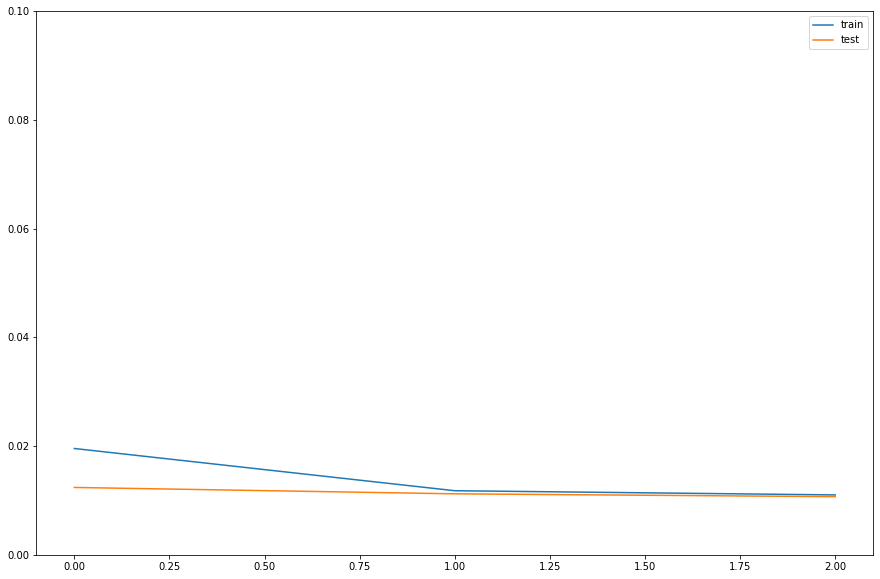

In [ ]:
# Train/Test loss chart
# MSE
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim(0, 0.1)
plt.legend()
plt.show()

In [ ]:
b

In [ ]:
y_samples.drop(y_samples[nan_rows].index)

,CO (t+0),NO2 (t+0),NO (t+0),PM10 (t+0),PM2.5 (t+0),CO (t+1),NO2 (t+1),NO (t+1),PM10 (t+1),PM2.5 (t+1),CO (t+2),NO2 (t+2),NO (t+2),PM10 (t+2),PM2.5 (t+2),CO (t+3),NO2 (t+3),NO (t+3),PM10 (t+3),PM2.5 (t+3),CO (t+4),NO2 (t+4),NO (t+4),PM10 (t+4),PM2.5 (t+4),CO (t+5),NO2 (t+5),NO (t+5),PM10 (t+5),PM2.5 (t+5),CO (t+6),NO2 (t+6),NO (t+6),PM10 (t+6),PM2.5 (t+6),CO (t+7),NO2 (t+7),NO (t+7),PM10 (t+7),PM2.5 (t+7),...,CO (t+64),NO2 (t+64),NO (t+64),PM10 (t+64),PM2.5 (t+64),CO (t+65),NO2 (t+65),NO (t+65),PM10 (t+65),PM2.5 (t+65),CO (t+66),NO2 (t+66),NO (t+66),PM10 (t+66),PM2.5 (t+66),CO (t+67),NO2 (t+67),NO (t+67),PM10 (t+67),PM2.5 (t+67),CO (t+68),NO2 (t+68),NO (t+68),PM10 (t+68),PM2.5 (t+68),CO (t+69),NO2 (t+69),NO (t+69),PM10 (t+69),PM2.5 (t+69),CO (t+70),NO2 (t+70),NO (t+70),PM10 (t+70),PM2.5 (t+70),CO (t+71),NO2 (t+71),NO (t+71),PM10 (t+71),PM2.5 (t+71)
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-30 03:40:00,0.0,0.0422,0.013,0.025,0.010,0.0,0.0434,0.014,0.026,0.011,0.0,0.0409,0.014,0.027,0.011,0.0,0.0376,0.007,0.026,0.011,0.0,0.0378,0.008,0.026,0.011,0.0,0.0402,0.015,0.026,0.010,0.0,0.0432,0.014,0.028,0.012,0.0,0.0371,0.006,0.027,0.017,...,0.0,0.0446,0.006,0.029,0.016,0.0,0.0562,0.029,0.031,0.016,0.0,0.0577,0.034,0.033,0.017,0.2,0.0550,0.060,0.038,0.019,0.1,0.0452,0.052,0.044,0.023,0.2,0.0410,0.063,0.046,0.021,0.4,0.0478,0.107,0.053,0.022,0.5,0.0603,0.118,0.055,0.022
2020-09-30 04:00:00,0.0,0.0434,0.014,0.026,0.011,0.0,0.0409,0.014,0.027,0.011,0.0,0.0376,0.007,0.026,0.011,0.0,0.0378,0.008,0.026,0.011,0.0,0.0402,0.015,0.026,0.010,0.0,0.0432,0.014,0.028,0.012,0.0,0.0371,0.006,0.027,0.017,0.0,0.0412,0.014,0.026,0.015,...,0.0,0.0562,0.029,0.031,0.016,0.0,0.0577,0.034,0.033,0.017,0.2,0.0550,0.060,0.038,0.019,0.1,0.0452,0.052,0.044,0.023,0.2,0.0410,0.063,0.046,0.021,0.4,0.0478,0.107,0.053,0.022,0.5,0.0603,0.118,0.055,0.022,0.4,0.0584,0.085,0.054,0.024
2020-09-30 04:20:00,0.0,0.0409,0.014,0.027,0.011,0.0,0.0376,0.007,0.026,0.011,0.0,0.0378,0.008,0.026,0.011,0.0,0.0402,0.015,0.026,0.010,0.0,0.0432,0.014,0.028,0.012,0.0,0.0371,0.006,0.027,0.017,0.0,0.0412,0.014,0.026,0.015,0.0,0.0453,0.030,0.029,0.015,...,0.0,0.0577,0.034,0.033,0.017,0.2,0.0550,0.060,0.038,0.019,0.1,0.0452,0.052,0.044,0.023,0.2,0.0410,0.063,0.046,0.021,0.4,0.0478,0.107,0.053,0.022,0.5,0.0603,0.118,0.055,0.022,0.4,0.0584,0.085,0.054,0.024,0.2,0.0541,0.042,0.050,0.022
2020-09-30 04:40:00,0.0,0.0376,0.007,0.026,0.011,0.0,0.0378,0.008,0.026,0.011,0.0,0.0402,0.015,0.026,0.010,0.0,0.0432,0.014,0.028,0.012,0.0,0.0371,0.006,0.027,0.017,0.0,0.0412,0.014,0.026,0.015,0.0,0.0453,0.030,0.029,0.015,0.1,0.0482,0.043,0.031,0.015,...,0.2,0.0550,0.060,0.038,0.019,0.1,0.0452,0.052,0.044,0.023,0.2,0.0410,0.063,0.046,0.021,0.4,0.0478,0.107,0.053,0.022,0.5,0.0603,0.118,0.055,0.022,0.4,0.0584,0.085,0.054,0.024,0.2,0.0541,0.042,0.050,0.022,0.1,0.0505,0.031,0.046,0.020
2020-09-30 05:00:00,0.0,0.0378,0.008,0.026,0.011,0.0,0.0402,0.015,0.026,0.010,0.0,0.0432,0.014,0.028,0.012,0.0,0.0371,0.006,0.027,0.017,0.0,0.0412,0.014,0.026,0.015,0.0,0.0453,0.030,0.029,0.015,0.1,0.0482,0.043,0.031,0.015,0.2,0.0495,0.054,0.035,0.021,...,0.1,0.0452,0.052,0.044,0.023,0.2,0.0410,0.063,0.046,0.021,0.4,0.0478,0.107,0.053,0.022,0.5,0.0603,0.118,0.055,0.022,0.4,0.0584,0.085,0.054,0.024,0.2,0.0541,0.042,0.050,0.022,0.1,0.0505,0.031,0.046,0.020,0.1,0.0522,0.030,0.044,0.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-30 22:40:00,0.2,0.0363,0.018,0.023,0.018,0.2,0.0363,0.017,0.021,0.017,0.2,0.0354,0.015,0.022,0.018,0.2,0.0334,0.011,0.024,0.020,0.3,0.0337,0.012,0.027,0.022,0.2,0.0335,0.011,0.028,0.023,0.2,0.0321,0.009,0.029,0.024,0.2,0.0312,0.008,0.027,0.023,...,0.2,0.0371,0.009,0.027,0.

In [ ]:
y_samples.isnull().any(axis=1)

datetime
2020-09-22 21:20:00    False
2020-09-22 21:40:00    False
2020-09-22 22:00:00    False
2020-09-22 22:20:00    False
2020-09-22 22:40:00    False
                       ...  
2020-12-31 22:20:00     True
2020-12-31 22:40:00     True
2020-12-31 23:00:00     True
2020-12-31 23:20:00     True
2020-12-31 23:40:00     True
Length: 5937, dtype: bool

In [ ]:
nan_rows = X_samples.isnull().any(axis=1) | y_samples.isnull().any(axis=1)

datetime
2020-09-22 21:20:00    True
2020-09-22 21:40:00    True
2020-09-22 22:00:00    True
2020-09-22 22:20:00    True
2020-09-22 22:40:00    True
                       ... 
2020-12-31 22:20:00    True
2020-12-31 22:40:00    True
2020-12-31 23:00:00    True
2020-12-31 23:20:00    True
2020-12-31 23:40:00    True
Length: 5937, dtype: bool

In [ ]:
X.columns.shape

(25,)

In [ ]:
n_train_hours = 3000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]X_samples.iloc[0].shape

(12960,)

In [ ]:
(25*504, 5*72)

(12600, 360)

In [ ]:
n_samples = X_samples[0]
n_timesteps = 504
n_features_in = 25#X.columns.shape[0]
n_features_out = 5

In [ ]:
X_samples.iloc[]

In [ ]:
X_samples.shape

(5362, 12960)

In [ ]:
X_samples.reshape()

In [ ]:
25*504+5*72

12960

In [ ]:
12960/(72+504)

22.5

In [ ]:
# split into train and test sets
values = X_samples.values
n_train_hours = 3000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

number_of_targ_feat = TARGET_PARAMS.__len__()
# split into input and outputs
train_X, train_y = train[:, :-number_of_targ_feat], train[:, -number_of_targ_feat:]
test_X, test_y = test[:, :-number_of_targ_feat], test[:, -number_of_targ_feat:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# # design network
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(number_of_targ_feat))
# model.compile(loss='mse', optimizer='adam')

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(100, activation='relu'))
model.add(Dense(number_of_targ_feat))
model.compile(optimizer='adam', loss='mse')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

(3000, 1, 13459) (3000, 5) (2362, 1, 13459) (2362, 5)
Epoch 1/50
42/42 - 8s - loss: 0.1183 - val_loss: 0.0471
Epoch 2/50
42/42 - 3s - loss: 0.0398 - val_loss: 0.0553
Epoch 3/50
42/42 - 3s - loss: 0.0445 - val_loss: 0.0749
Epoch 4/50
42/42 - 3s - loss: 0.0601 - val_loss: 0.0272
Epoch 5/50


KeyboardInterrupt: ignored

In [ ]:
# split into train and test sets
values = X_samples.values
n_train_hours = 3000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

number_of_targ_feat = TARGET_PARAMS.__len__()
# split into input and outputs
train_X, train_y = train[:, :-number_of_targ_feat], train[:, -number_of_targ_feat:]
test_X, test_y = test[:, :-number_of_targ_feat], test[:, -number_of_targ_feat:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3000, 1, 13459) (3000, 5) (2362, 1, 13459) (2362, 5)


In [ ]:
13459/

434.16129032258067

In [ ]:
X_samples

,CO (t-504),NO2 (t-504),NO (t-504),PM10 (t-504),PM2.5 (t-504),-T- (t-504),| V | (t-504),_V_ (t-504),Давление (t-504),Влажность (t-504),Осадки (t-504),0 (t-504),50 (t-504),100 (t-504),150 (t-504),200 (t-504),250 (t-504),300 (t-504),350 (t-504),400 (t-504),450 (t-504),500 (t-504),550 (t-504),600 (t-504),OutsideTemperature (t-504),Quality (t-504),CO (t-503),NO2 (t-503),NO (t-503),PM10 (t-503),PM2.5 (t-503),-T- (t-503),| V | (t-503),_V_ (t-503),Давление (t-503),Влажность (t-503),Осадки (t-503),0 (t-503),50 (t-503),100 (t-503),...,CO (t+64),NO2 (t+64),NO (t+64),PM10 (t+64),PM2.5 (t+64),CO (t+65),NO2 (t+65),NO (t+65),PM10 (t+65),PM2.5 (t+65),CO (t+66),NO2 (t+66),NO (t+66),PM10 (t+66),PM2.5 (t+66),CO (t+67),NO2 (t+67),NO (t+67),PM10 (t+67),PM2.5 (t+67),CO (t+68),NO2 (t+68),NO (t+68),PM10 (t+68),PM2.5 (t+68),CO (t+69),NO2 (t+69),NO (t+69),PM10 (t+69),PM2.5 (t+69),CO (t+70),NO2 (t+70),NO (t+70),PM10 (t+70),PM2.5 (t+70),CO (t+71),NO2 (t+71),NO (t+71),PM10 (t+71),PM2.5 (t+71)
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-30 03:40:00,0.038462,0.286830,0.003195,0.090535,0.225806,0.797059,0.368421,0.665738,0.350725,0.555723,0.0,0.788618,0.805877,0.789660,0.790594,0.793833,0.799751,0.803321,0.806049,0.810020,0.816285,0.825524,0.834290,0.843577,0.791545,0.0,0.038462,0.296875,0.006390,0.082305,0.258065,0.791176,0.280702,0.459610,0.353623,0.572289,0.0,0.779326,0.801722,0.785524,...,0.000000,0.429688,0.007435,0.119342,0.313725,0.000000,0.559152,0.092937,0.127572,0.313725,0.000000,0.575893,0.111524,0.135802,0.333333,0.142857,0.545759,0.208178,0.156379,0.372549,0.071429,0.436384,0.178439,0.181070,0.450980,0.142857,0.389509,0.219331,0.189300,0.411765,0.285714,0.465402,0.382900,0.218107,0.431373,0.357143,0.604911,0.423792,0.226337,0.431373
2020-09-30 04:00:00,0.038462,0.296875,0.006390,0.082305,0.258065,0.791176,0.280702,0.459610,0.353623,0.572289,0.0,0.779326,0.801722,0.785524,0.786454,0.788996,0.794768,0.800447,0.804076,0.808339,0.815600,0.826224,0.836801,0.847994,0.785423,0.0,0.038462,0.304688,0.006390,0.078189,0.193548,0.788235,0.385965,0.768802,0.356522,0.579819,0.0,0.783972,0.798457,0.779616,...,0.000000,0.559152,0.092937,0.127572,0.313725,0.000000,0.575893,0.111524,0.135802,0.333333,0.142857,0.545759,0.208178,0.156379,0.372549,0.071429,0.436384,0.178439,0.181070,0.450980,0.142857,0.389509,0.219331,0.189300,0.411765,0.285714,0.465402,0.382900,0.218107,0.431373,0.357143,0.604911,0.423792,0.226337,0.431373,0.285714,0.583705,0.301115,0.222222,0.470588
2020-09-30 04:20:00,0.038462,0.304688,0.006390,0.078189,0.193548,0.788235,0.385965,0.768802,0.356522,0.579819,0.0,0.783972,0.798457,0.779616,0.780834,0.785973,0.793211,0.799489,0.804076,0.809348,0.817995,0.829720,0.841105,0.853147,0.785131,0.0,0.038462,0.312500,0.006390,0.074074,0.161290,0.785294,0.333333,0.562674,0.356522,0.596386,0.0,0.774100,0.795785,0.779616,...,0.000000,0.575893,0.111524,0.135802,0.333333,0.142857,0.545759,0.208178,0.156379,0.372549,0.071429,0.436384,0.178439,0.181070,0.450980,0.142857,0.389509,0.219331,0.189300,0.411765,0.285714,0.465402,0.382900,0.218107,0.431373,0.357143,0.604911,0.423792,0.226337,0.431373,0.285714,0.583705,0.301115,0.222222,0.470588,0.142857,0.535714,0.141264,0.205761,0.431373
2020-09-30 04:40:00,0.038462,0.312500,0.006390,0.074074,0.161290,0.785294,0.333333,0.562674,0.356522,0.596386,0.0,0.774100,0.795785,0.779616,0.780538,0.783253,0.790408,0.795019,0.798488,0.802959,0.810469,0.820979,0.831779,0.842841,0.780175,0.0,0.076923,0.330357,0.006390,0.074074,0.161290,0.776471,0.280702,0.713092,0.356522,0.615964,0.0,0.761614,0.781538,0.766322,...,0.142857,0.545759,0.208178,0.156379,0.372549,0.071429,0.436384,0.178439,0.181070,0.450980,0.142857,0.389509,0.219331,0.189300,0.411765,0.285714,0.465402,0.382900,0.218107,0.431373,0.357143,0.604911,0.423792,0.226337,0.431373,0.285714,0.583705,0.301115,0.222222,0.470588,0.142857,0.535714,0.141264,0.205761,0.431373,0.071429,0.495536,0.100372,0.189300,0.392157
2020-09-30 05:

In [ ]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
df_samples = split_sequences(X, n_steps_in=n_steps_in, n_steps_out=n_steps_out)

TypeError: ignored

In [ ]:
# demonstrate prediction
x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

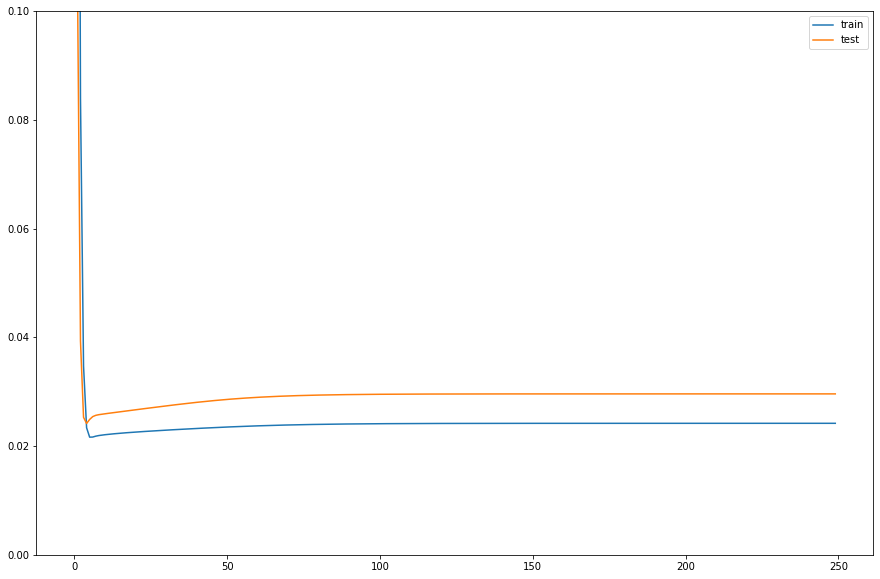

In [ ]:
# Train/Test loss chart
# MSE
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylim(0, 0.1)
plt.legend()
plt.show()

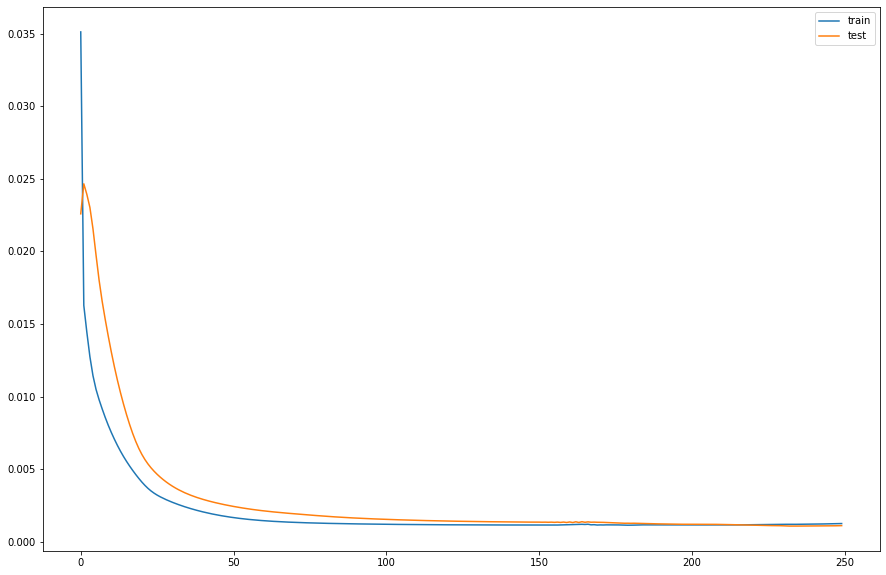

In [ ]:
# Train/Test loss chart
# MSE
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

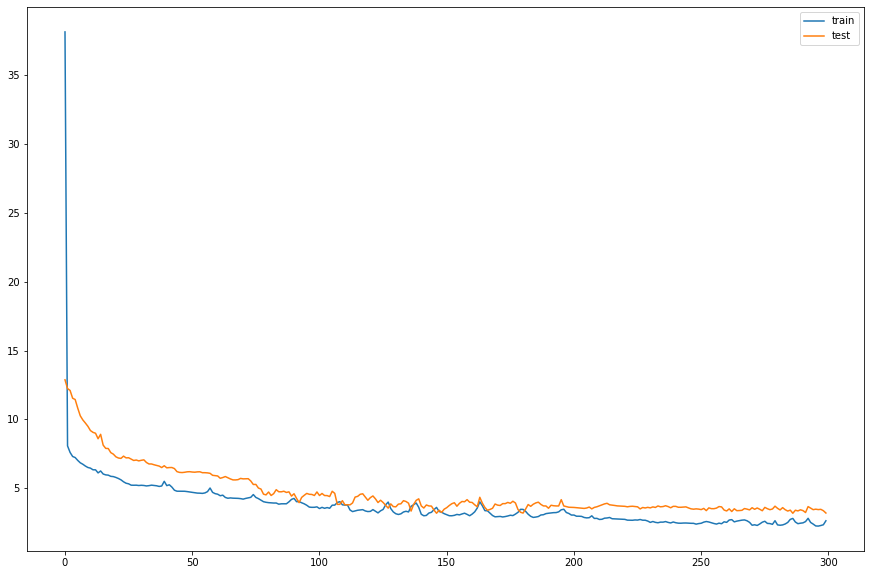

In [ ]:
# Train/Test loss chart
# MAPE 
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
y_hat = pd.DataFrame(data=y_hat, columns=TARGET_PARAMS)

In [ ]:
y_hat = model.predict(test_X)

In [ ]:
y_hat.shape

(2362, 5)

In [ ]:
y_hat = model.predict(test_X)
test_back = np.concatenate((test_X.reshape(test_X.shape[0], test_X.shape[2]), y_hat), axis=1)
test_back_scaled = scaler.inverse_transform(test_back)
df_res = pd.DataFrame(data=test_back_scaled, columns=X_samples.columns)b

In [ ]:
test_back_y = np.concatenate((test_X.reshape(test_X.shape[0], test_X.shape[2]), test_y), axis=1)
test_back_y_scaled = scaler.inverse_transform(test_back_y)
initial_y = pd.DataFrame(data=test_back_y_scaled[::, -5::], columns=X.columns[:5:])

In [ ]:
test_back_y_scaled[::, -5::].shape, X.columns[:5:].shape

((2936, 5), (5,))

In [ ]:
X.columns

Index(['CO', 'NO2', 'NO', 'PM10', 'PM2.5', '-T-', '| V |', '_V_', 'Давление',
       'Влажность', 'Осадки', '0', '50', '100', '150', '200', '250', '300',
       '350', '400', '450', '500', '550', '600', 'OutsideTemperature',
       'Quality'],
      dtype='object')

In [ ]:
y_hat.shape

(2936, 5)

In [ ]:
initial_y

,CO,NO2,NO,PM10,PM2.5
0,0.0,0.0194,0.012,0.008,0.005
1,0.0,0.0202,0.011,0.009,0.005
2,0.0,0.0247,0.014,0.010,0.006
3,0.3,0.0302,0.017,0.000,0.000
4,0.4,0.0291,0.017,0.000,0.000
...,...,...,...,...,...
2931,0.1,0.0310,0.006,0.020,0.017
2932,0.1,0.0397,0.008,0.022,0.018
2933,0.1,0.0424,0.010,0.025,0.019
2934,0.2,0.0396,0.009,0.026,0.020


In [ ]:
df_tp = df_res.iloc[::, -5::]

In [ ]:
relative_val = y_hat/test_y

In [ ]:
relative_val.shape

(2936, 5)

In [ ]:
X

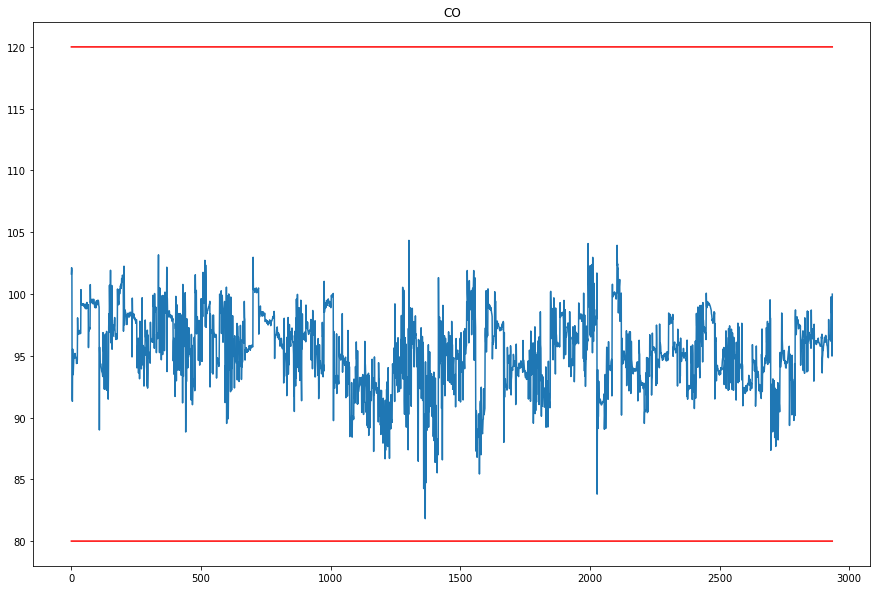

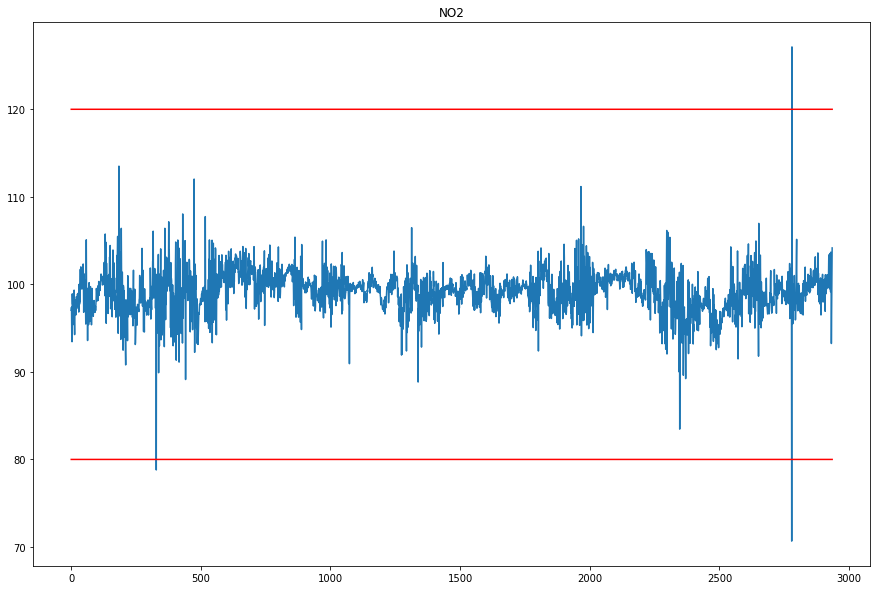

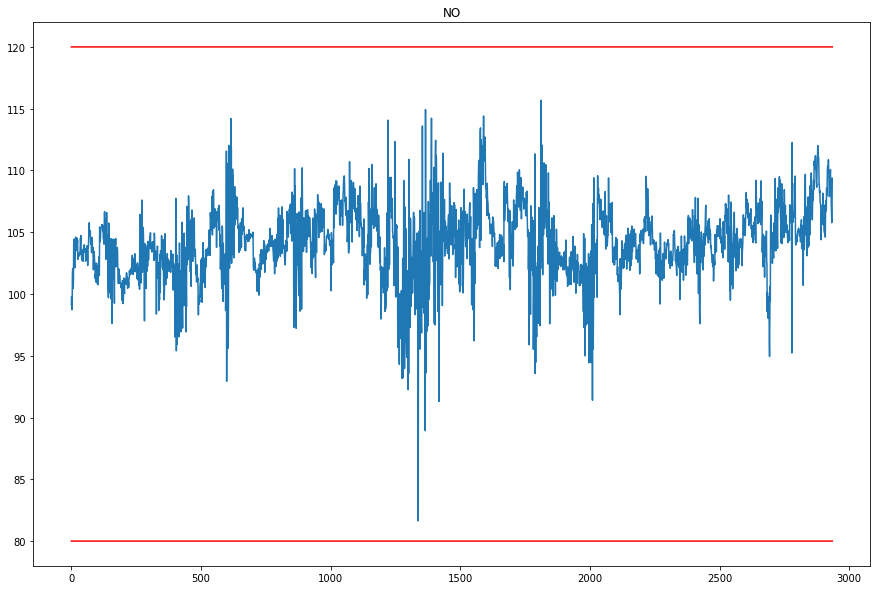

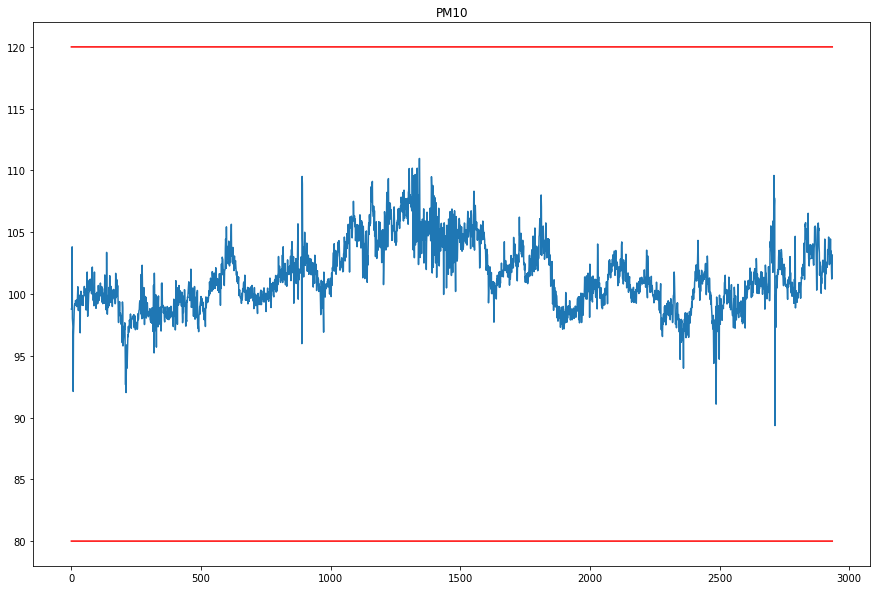

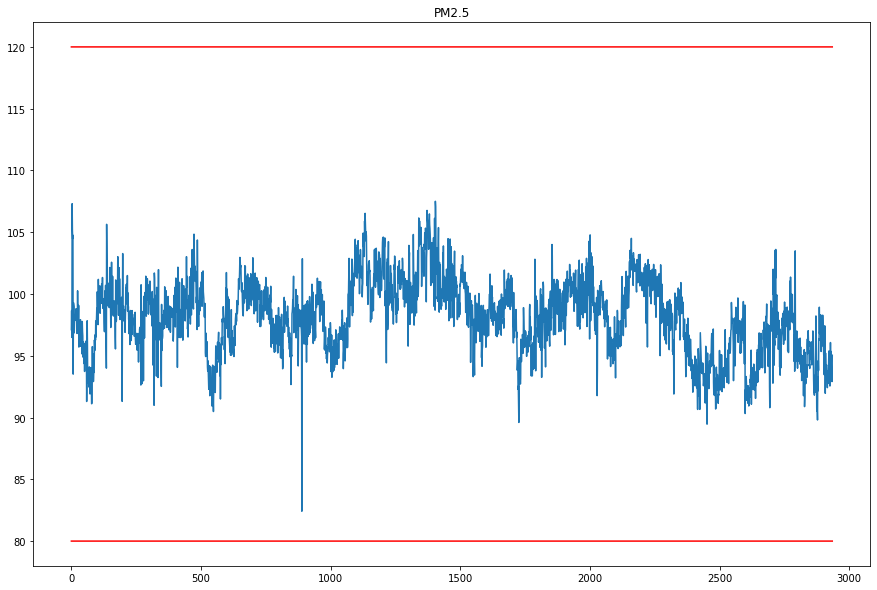

In [ ]:
for ind in range(5):
    plt.figure(figsize=(15, 10))
    plt.title(TARGET_PARAMS[ind])
    #plt.plot(y_hat[::, )
    plt.plot(100*relative_val[::, ind])
    plt.plot(relative_val.shape[0]*[80], color='red')
    plt.plot(relative_val.shape[0]*[120], color='red')
    #plt.xlim(0, 1000)
    plt.show()

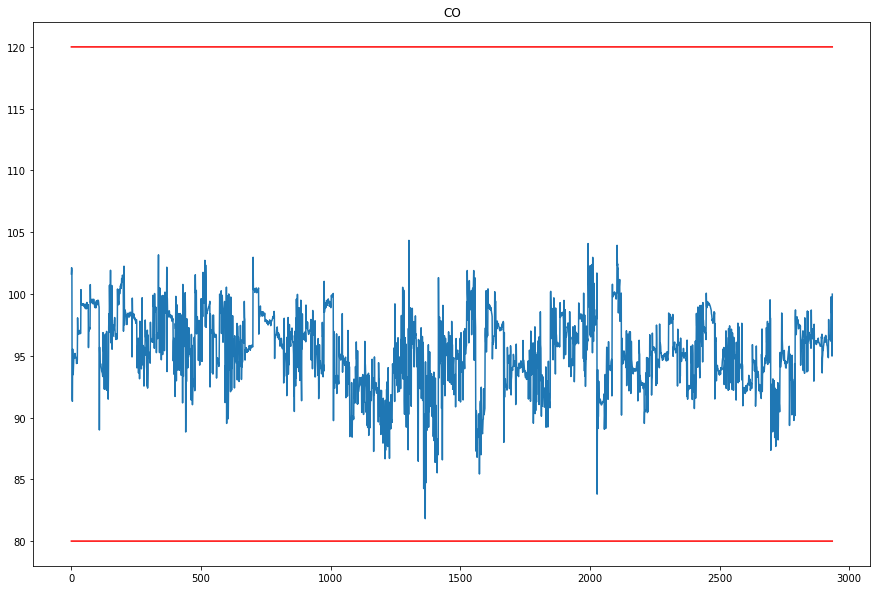

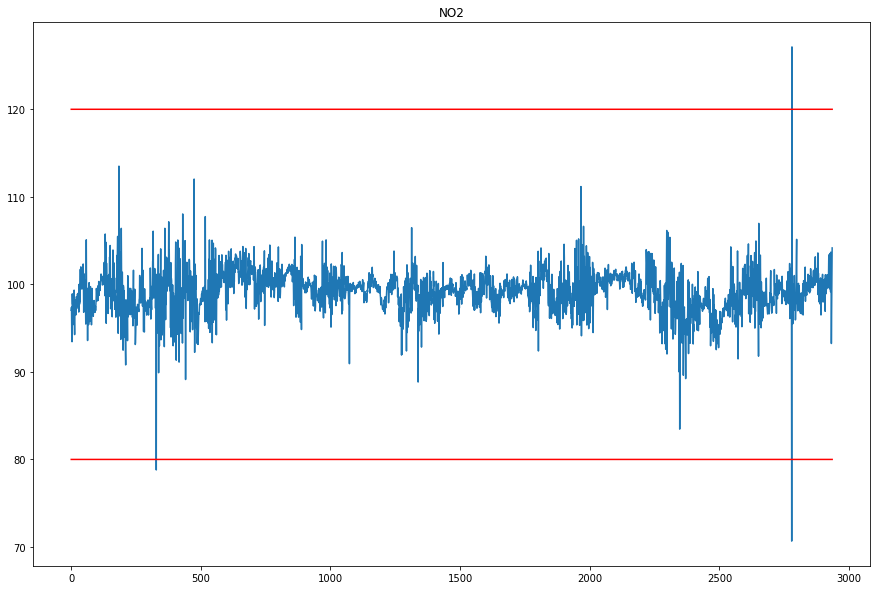

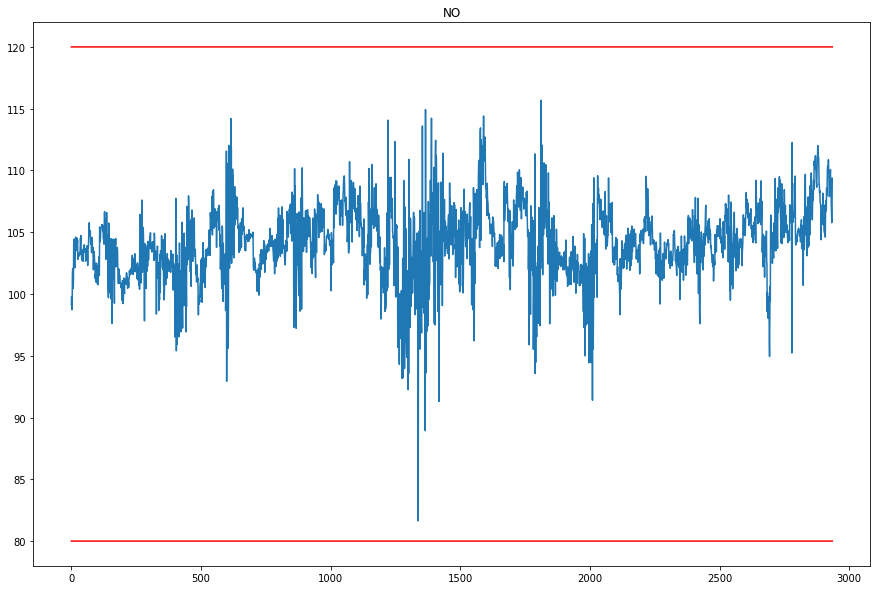

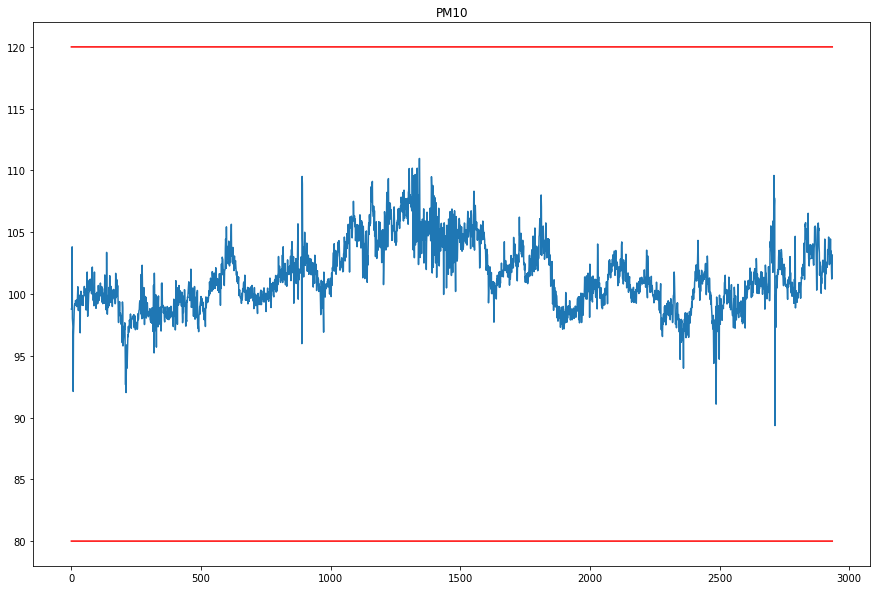

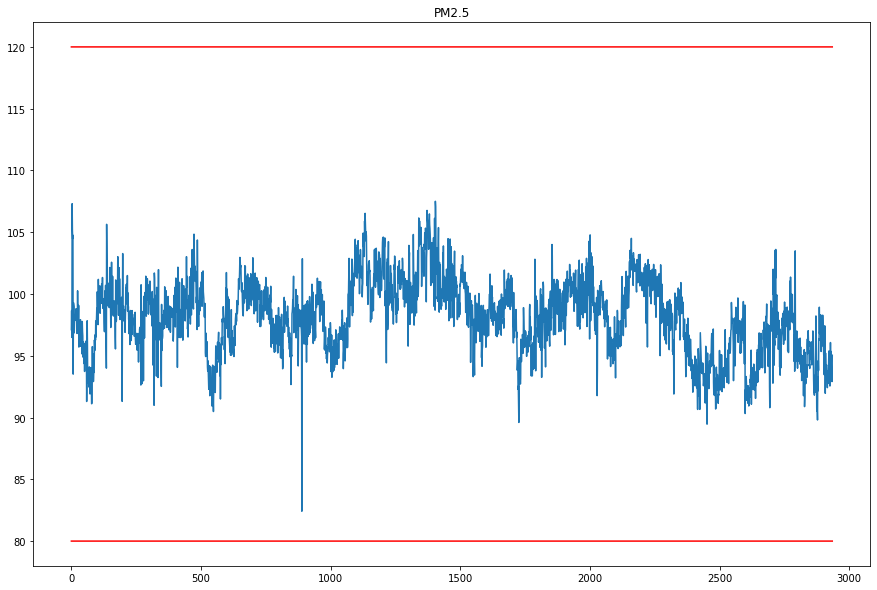

In [ ]:
for ind in range(5):
    plt.figure(figsize=(15, 10))
    plt.title(TARGET_PARAMS[ind])
    #plt.plot(y_hat[::, )
    plt.plot(100*relative_val[::, ind])
    plt.plot(relative_val.shape[0]*[80], color='red')
    plt.plot(relative_val.shape[0]*[120], color='red')
    #plt.xlim(0, 1000)
    plt.show()

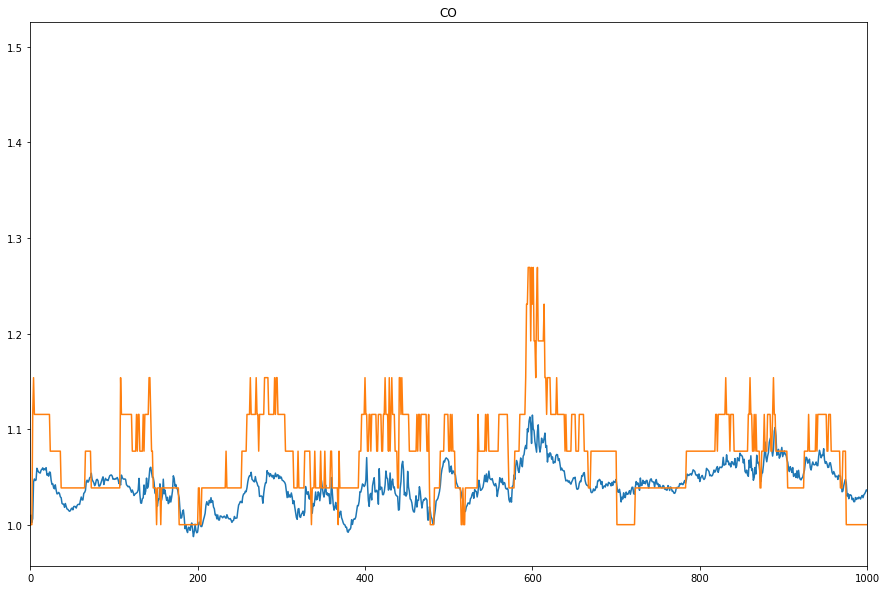

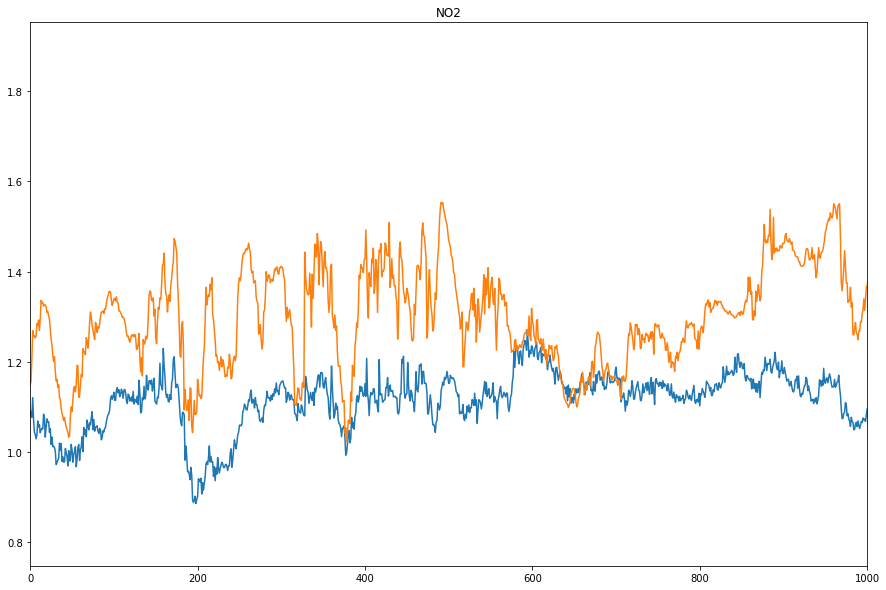

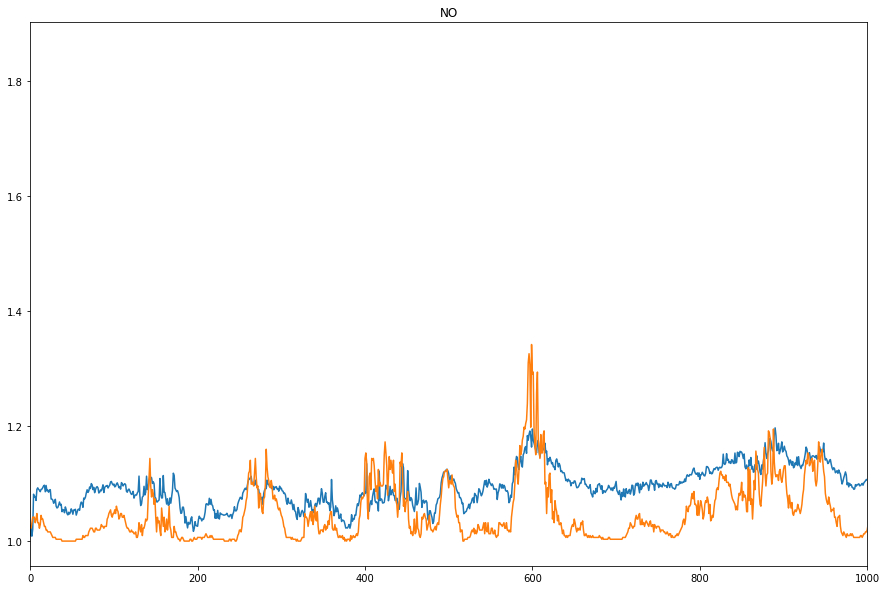

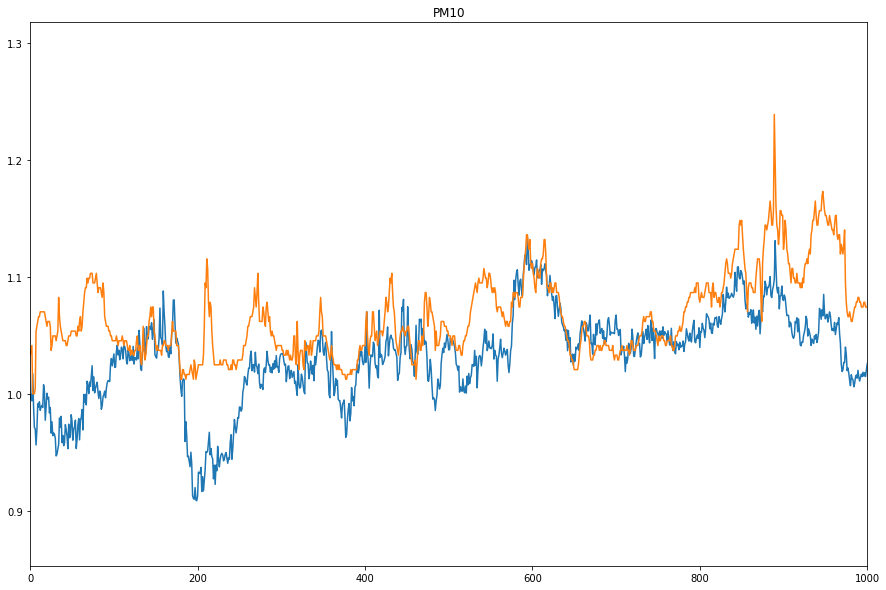

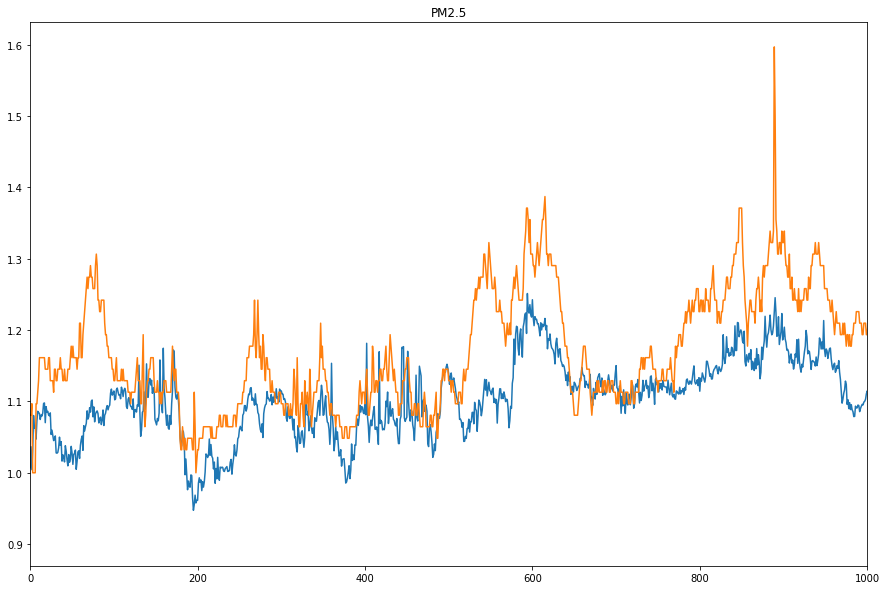

In [ ]:
for ind in range(5):
    plt.figure(figsize=(15, 10))
    plt.title(TARGET_PARAMS[ind])
    plt.plot(y_hat[::, ind])
    plt.plot(test_y[::, ind])
    plt.xlim(0, 1000)
    plt.show()

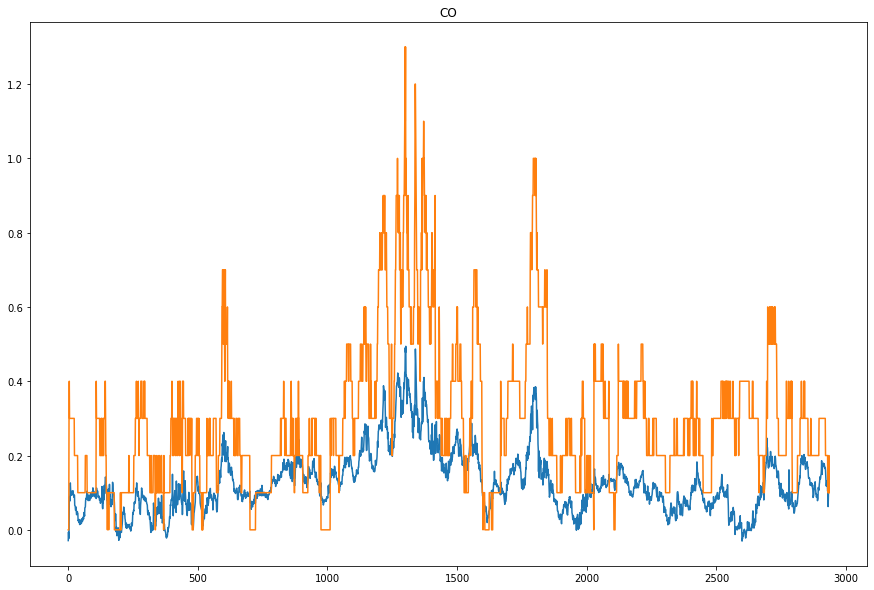

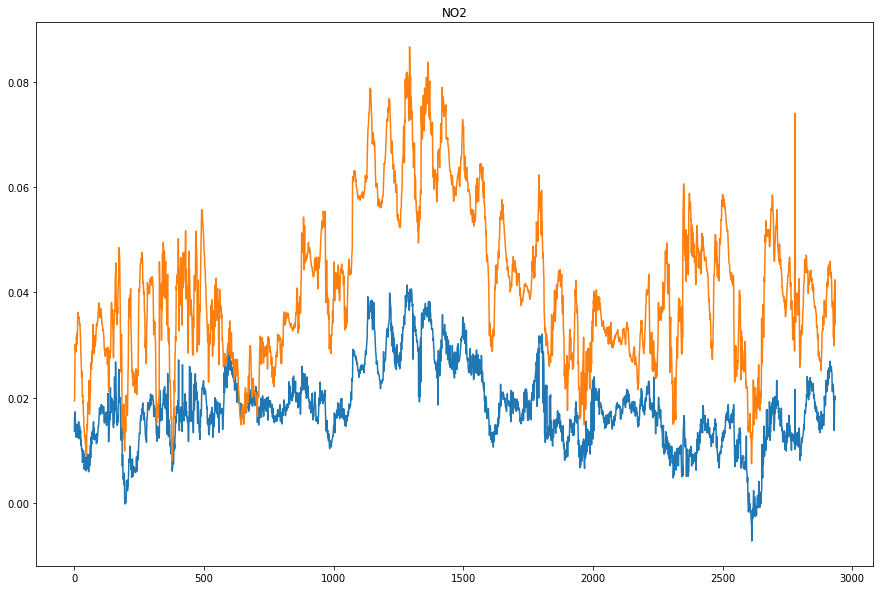

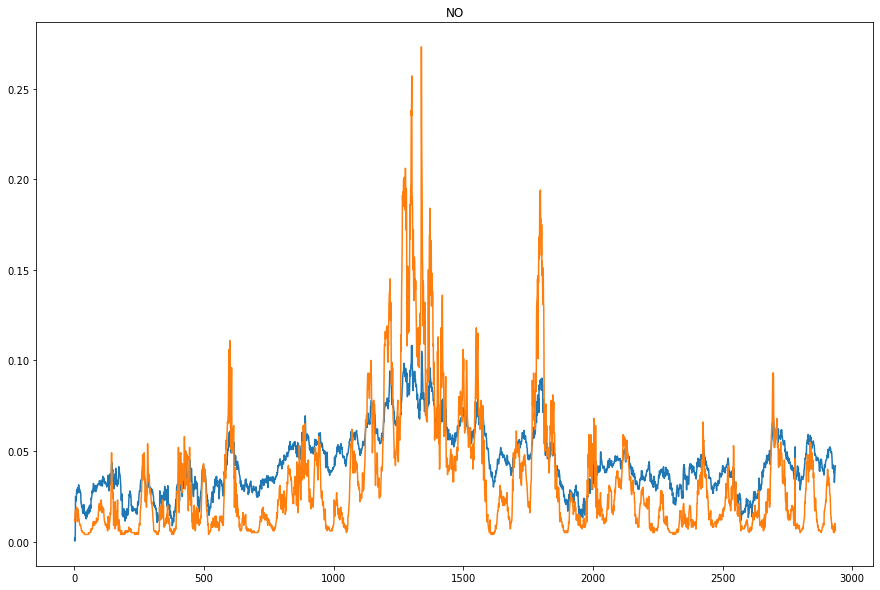

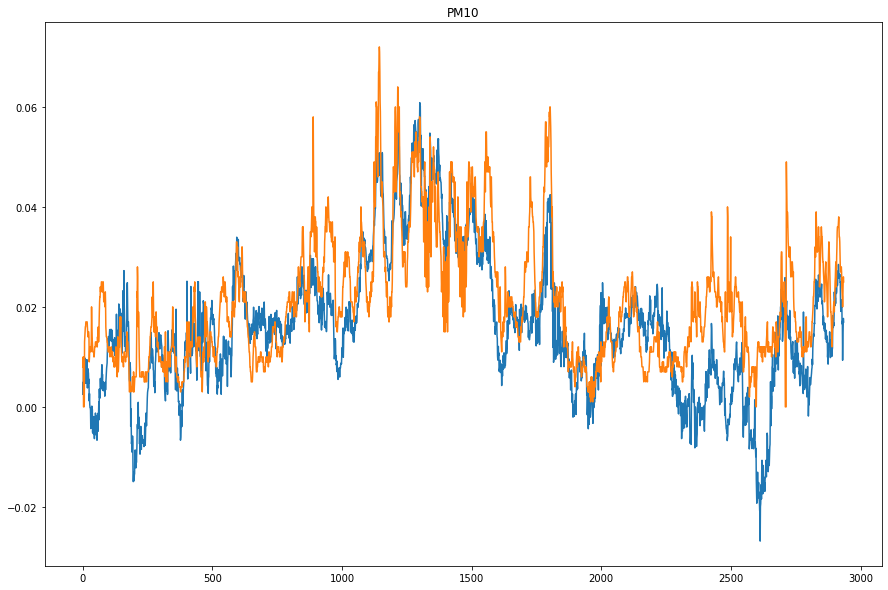

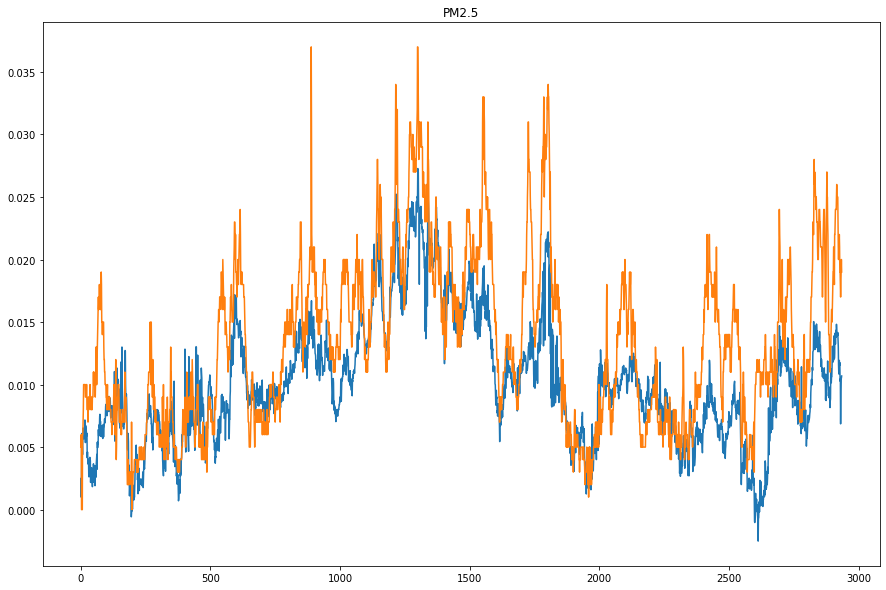

In [ ]:
for ind in range(5):
    plt.figure(figsize=(15, 10))
    plt.title(TARGET_PARAMS[ind])
    df_t[::, ind].plot()
    initial_y.iloc[::, ind].plot()
    plt.show()

In [ ]:
y_hat.shape

(2936, 5)

In [ ]:
y_hat.reshape()

AttributeError: ignored

In [ ]:
train_X.shape

(3000, 1, 26)

In [ ]:
X_samples.shape

(5936, 31)

In [ ]:
test_back_tm = test_X[:,:, :-number_of_targ_feat:,]

In [ ]:
test_back_tm.shape

(2936, 1, 21)

In [ ]:
test_back_tm= test_back_tm.reshape(test_back_tm.shape[0], test_back_tm.shape[2])

In [ ]:
test_X.reshape(test_X.shape[0], test_X.shape[2])

(2936, 1, 26)

In [ ]:
test_back = np.concatenate((test_X.reshape(test_X.shape[0], test_X.shape[2]), y_hat), axis=1)

In [ ]:
test_back.shape

(2936, 26)

In [ ]:
X_samples.shape

(5936, 31)

In [ ]:
test_back_scaled = scaler.inverse_transform(test_back)

In [ ]:
df_res = pd.DataFrame(data=test_back_scaled, columns=X_samples.columns)

In [ ]:
df_res.head()

,CO (t-1),NO2 (t-1),NO (t-1),PM10 (t-1),PM2.5 (t-1),-T- (t-1),| V | (t-1),_V_ (t-1),Давление (t-1),Влажность (t-1),Осадки (t-1),0 (t-1),50 (t-1),100 (t-1),150 (t-1),200 (t-1),250 (t-1),300 (t-1),350 (t-1),400 (t-1),450 (t-1),500 (t-1),550 (t-1),600 (t-1),OutsideTemperature (t-1),Quality (t-1),CO (t+0),NO2 (t+0),NO (t+0),PM10 (t+0),PM2.5 (t+0)
0,0.0,0.0174,0.010,0.008,0.004,6.8,3.3,274.0,741.0,79.1,0.0,7.10,6.60,6.14,5.70,5.24,4.75,4.29,3.88,3.53,3.20,2.90,2.60,2.30,6.87,0.0,-0.010497,0.008563,0.001155,0.000684,0.001134
1,0.0,0.0194,0.012,0.008,0.005,7.1,4.0,166.0,741.1,77.5,0.0,6.88,6.84,6.52,6.04,5.59,5.03,4.46,3.98,3.58,3.20,2.84,2.49,2.13,6.90,0.0,-0.017173,0.011379,0.004844,0.003897,0.003058
2,0.0,0.0202,0.011,0.009,0.005,7.1,3.8,283.0,741.3,76.1,0.0,6.93,6.97,6.63,6.20,5.71,5.12,4.61,4.15,3.74,3.36,3.00,2.65,2.30,7.13,0.0,-0.016433,0.009318,0.000942,0.001228,0.001183
3,0.0,0.0247,0.014,0.010,0.006,7.2,3.1,258.0,741.3,75.3,0.0,7.11,7.13,6.76,6.28,5.78,5.25,4.72,4.25,3.86,3.49,3.15,2.83,2.50,7.19,0.0,-0.014139,0.013107,0.003978,0.006138,0.002931
4,0.3,0.0302,0.017,0.000,0.000,0.5,3.3,149.0,752.9,92.0,0.0,0.35,0.41,0.33,0.01,-0.22,-0.45,-0.58,-0.56,-0.50,-0.49,-0.46,-0.37,-0.28,0.34,0.0,0.056146,0.014184,0.015484,0.004542,0.006150


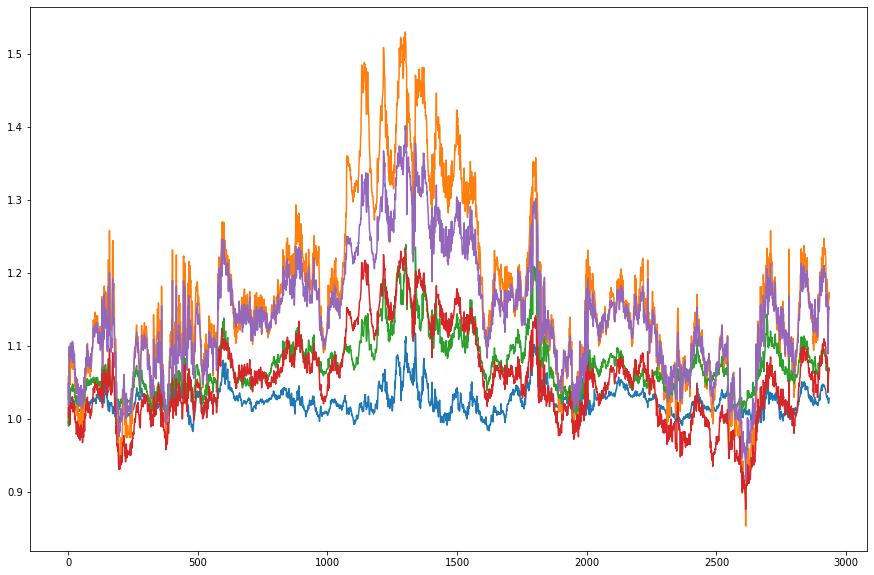

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(y_hat)


In [ ]:
X.shape

NameError: ignored

In [ ]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
# split into train and test sets
values = X_samples.values
n_train_hours = 3000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

number_of_targ_feat = TARGET_PARAMS.__len__()
# split into input and outputs
train_X, train_y = train[:, :-number_of_targ_feat], train[:, -number_of_targ_feat:]
test_X, test_y = test[:, :-number_of_targ_feat], test[:, -number_of_targ_feat:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

n_input = 30
n_output = 25
n_features = 30
# design network
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(RepeatVector(n_output))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mape')
# fit network
history = model.fit(train_X, train_y, epochs=25, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

